# Import

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pysam
import seaborn as sns
from pyliftover import LiftOver
from matplotlib_venn import venn2

In [4]:
# Define the parameters used to create the plots
rc = {'figure.figsize':(7,7),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20,    
      'font.sans-serif': 'Arial',
      'font.family': 'sans-serif',
      'svg.fonttype' : 'none'}


# (A) Comparison to GTEx dataset

In [5]:
def convert_to_hg38(file):

    # Function to convert coordinates
    def convert_coordinate(chr, coord):
        converted = []
        converted_coord = lo.convert_coordinate(chr, coord)
        if converted_coord:
            return converted_coord[0][1]
        else:
            return 'NA'
    # Read your file into a DataFrame
    df = pd.read_csv(file,
                    sep='\t',
                    header=None,
                    names=['Gene', 'Paralog', 'Chr', 'Strand', 'TxStart', 'TxEnd', 'hg19ESS', 'hg19EES'])

    # Create a LiftOver object for hg19 to hg38 conversion
    lo = LiftOver('hg19', 'hg38')
        
    for index, row in df.iterrows():
        chr = row['Chr']
        df.at[index, 'TxStart38'] = convert_coordinate(chr, row['TxStart'])
        df.at[index, 'TxEnd38'] = convert_coordinate(chr, row['TxEnd'])
        ESS38 = []
        for coord in row['hg19ESS'].split(',')[:-1]:
            ESS38.append(convert_coordinate(chr, int(coord)))
        ESS38 = ','.join(map(str, ESS38))
        EES38 = []
        for coord in row['hg19EES'].split(',')[:-1]:
            EES38.append(convert_coordinate(chr, int(coord)))
        EES38 = ','.join(map(str, EES38))
        df.at[index, 'hg38ESS'] = ESS38
        df.at[index, 'hg38EES'] = EES38

    df['Chr'] = df['Chr'].str.replace('chr', '')

    return df

# Convert gtex from hg19 to hg38
gtex = convert_to_hg38('../datasets/gtex_dataset.txt')

retina = pd.read_csv('../datasets/retina_dataset.txt',
                    sep='\t',
                    header=None,
                    names=['Gene', 'Paralog', 'Chr', 'Strand', 'TxStart', 'TxEnd', 'ESS', 'EES'])

In [6]:
# Create a set for TxStart, TxEnt, ESS and EES
def populate_sets_from_dataframe(dataframe, txstart_col, txend_col, ess_col, ees_col):
    txstart_set = set()
    txend_set = set()
    ess_set = set()
    ees_set = set()

    for index, row in dataframe.iterrows():
        txstart_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(row[txstart_col]))
        txend_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(row[txend_col]))

        ess = row[ess_col].rstrip(',').split(',')
        for i in ess:
            ess_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(i))
        ees = row[ees_col].rstrip(',').split(',')
        for i in ees:
            ees_set.add(str(row['Gene'] + ':' + row['Chr']) + ':'+ row['Strand'] + ':' + str(i))

    return txstart_set, txend_set, ess_set, ees_set

retina_txstart, retina_tx_end, retina_ess, retina_ees = populate_sets_from_dataframe(
    retina, 'TxStart', 'TxEnd', 'ESS', 'EES')

gtex_txstart, gtex_tx_end, gtex_ess, gtex_ees = populate_sets_from_dataframe(
    gtex, 'TxStart38', 'TxEnd38', 'hg38ESS', 'hg38EES')

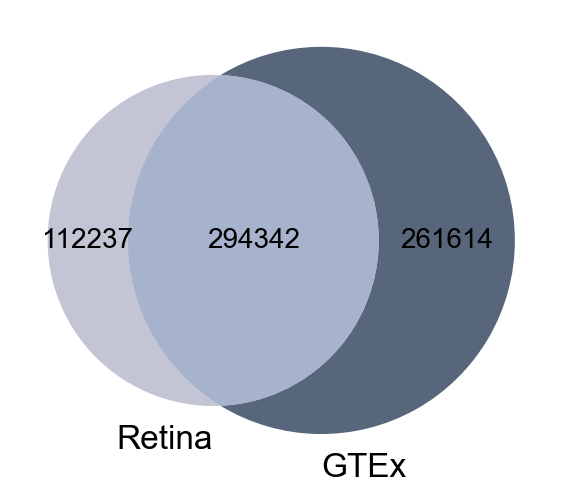

In [7]:

retina_ss = retina_ess.union(retina_ees)
gtex_ss = gtex_ess.union(gtex_ees)

plt.rcParams.update(rc)

# Create a Venn diagram
venn2(subsets=(len(retina_ss - gtex_ss), len(gtex_ss - retina_ss), len(retina_ss & gtex_ss)),
      set_labels=('Retina', 'GTEx'), set_colors=('#AAADC4', '#102542'), alpha = 0.7)

# Display the diagram
plt.savefig('plots/Trainingdata_overlapwithgtex.svg',  bbox_inches='tight', dpi = 300)
plt.show()


# (B) Splice junction motif

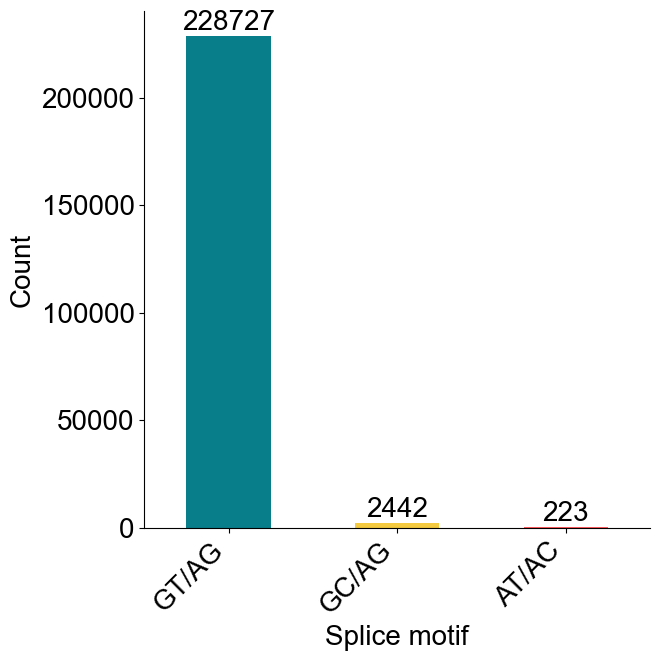

In [9]:
# Load the star splice junction
star = pd.read_csv('../datasets/SJ.retina.tab', sep = '\t', names = ['chr','start', 'end', 'strand','intron','annotated','number_of_reads', 'multimapping', 'overhang'], low_memory=False)

# remove junctions on mitochondrial chromosomes 
star = star[star['chr'] != 'MT']

# Group the juncctions, add a number of samples column, and combine the number of reads of the different samples
result_df = star.groupby(['chr', 'start', 'end', 'strand', 'intron', 'annotated']).agg(samples=('number_of_reads', 'size'), reads=('number_of_reads', 'sum')).reset_index()
result_df = result_df[result_df['samples'] >= 15]

# Load the training data
retina = pd.read_csv('../datasets/retina_dataset.txt', sep='\t', header=None,
                    names=['Gene', 'Paralog', 'Chr', 'Strand', 'TxStart', 'TxEnd', 'ESS', 'EES'])

# Create a dictionary to look up if a splice junction is in the training data
training_data = {}
for index, row in retina.iterrows():
    chr = row['Chr']
    if chr in training_data.keys():
        for i in row['ESS'].split(','):
            training_data[chr].append(i)
    else:
        training_data[chr] = [i for i in row['ESS'].split(',')]

# Function to check if start is in training_data for the corresponding chr
def check_in_training_data(row):
    chr = row['chr']
    start = row['start']-1
    return str(start) in training_data.get(chr, [])

# Apply the function to each row
result_df['in_training_data'] = result_df.apply(check_in_training_data, axis=1)

# Filter the DataFrame based on the new column
junction_in_train = result_df[result_df['in_training_data']]

# Sample data 
counts = junction_in_train['intron'].value_counts()

# Combine the counts
combined_counts = {
    'GT/AG': counts.get(1, 0) + counts.get(2, 0),
    'GC/AG': counts.get(3, 0) + counts.get(4, 0),
    'AT/AC': counts.get(5, 0) + counts.get(6, 0),
}

# Convert to DataFrame for better visualization
combined_counts_df = pd.DataFrame(list(combined_counts.items()), columns=['Motif', 'Count'])

plt.rcParams.update(rc)

# Create the bar plot with no edge color
p = combined_counts_df.plot(kind='bar', x='Motif', y='Count', legend=False, color=['#087E8B', '#F3CA40', '#FF5A5F'])

plt.xlabel('Splice motif')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Define x-axis labels in the order of the value counts
x_labels = ['GT/AG','GC/AG', 'AT/AC']

# Rename the x-axis labels
plt.gca().set_xticklabels(x_labels)

# Add numbers as labels
p.bar_label(p.containers[0], label_type='edge', color = 'black')

# Remove black x and y axis line
sns.despine(bottom = False, left = False)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('plots/Trainingdata_splicejunctions.svg',  bbox_inches='tight', dpi = 300)

plt.show()